In [27]:
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # for printing time stamps
import requests # for file gathering, if needed

import atlasopenmagic as atom
atom.available_releases()
atom.set_release('2025e-13tev-beta')
all_mc = atom.get_urls('data')

skim = "exactly4lep"
defs = {
    r'Data':{'dids':['data']},
    r'Background $Z,t\bar{t},t\bar{t}+V,VVV$':{'dids': [410470,410155,410218,
                                                        410219,412043,364243,
                                                        364242,364246,364248,
                                                        700320,700321,700322,
                                                        700323,700324,700325], 'color': "#6b59d3" }, # purple
    r'Background $ZZ^{*}$':     {'dids': [700600],'color': "#ff0000" },# red
    r'Signal ($m_H$ = 125 GeV)':  {'dids': [345060, 346228, 346310, 346311, 346312,
                                          346340, 346341, 346342],'color': "#00cdff" },# light blue
}

samples   = atom.build_dataset(defs, skim=skim, protocol='https', cache=True)
print(samples)

Release '2025e-13tev-beta' already active with cached metadata.
Active release: 2025e-13tev-beta. (Datasets path: REMOTE)


Available releases:
2016e-8tev           2016 Open Data for education release of 8 TeV proton-proton collisions (https://opendata.cern.ch/record/3860).
2020e-13tev          2020 Open Data for education release of 13 TeV proton-proton collisions (https://cern.ch/2r7xt).
2024r-pp             2024 Open Data for research release for proton-proton collisions (https://opendata.cern.record/80020).
2024r-hi             2024 Open Data for research release for heavy-ion collisions (https://opendata.cern.ch/record/80035).
2025e-13tev-beta     2025 Open Data for education and outreach beta release for 13 TeV proton-proton collisions (https://opendata.cern.ch/record/93910).
2025r-evgen-13tev    2025 Open Data for research release for event generation at 13 TeV (https://opendata.cern.ch/record/160000).
2025r-evgen-13p6tev  2025 Open Data for research release for event generation at 13.6 TeV (https://opendata.cern.ch/record/160000).
{'Data': {'list': ['simplecache::https://opendata.cern.ch/eos/openda

In [28]:
# Store event counts
event_totals = {}
event_counts = {
    "sample": [],
    "nIn": []
}

variables = ['lep_pt','lep_eta','lep_phi','lep_e','lep_charge','lep_type','trigE','trigM','lep_isTrigMatched',
            'lep_isLooseID','lep_isMediumID','lep_isLooseIso','lep_type']
weight_variables = ["filteff","kfac","xsec","mcWeight","ScaleFactor_PILEUP", "ScaleFactor_ELE", "ScaleFactor_MUON", "ScaleFactor_LepTRIGGER"]


In [29]:
for s in samples:
    # Print which sample is being processed
    print('Processing '+s+' samples')

    # Define empty list to hold data
    frames = []
    event_totals[s] = 0
    # Loop over each file
    for val in samples[s]['list']:
        if s == 'data':
            prefix = "Data/" # Data prefix
        else: # MC prefix
            prefix = "MC/mc_"
        fileString = val

        # start the clock
        start = time.time()
        print("\t"+val+":")

        # Open file
        tree = uproot.open(fileString + ":analysis")
        for data in tree.iterate(variables + weight_variables + ["sum_of_weights", "lep_n"],
                                 library="ak",
                                 entry_stop=tree.num_entries*1.0):#, # process up to numevents*fraction
            
            nIn = len(data)
            event_totals[s] += nIn
            
            event_counts["sample"].append(s)
            event_counts["nIn"].append(nIn)

Processing Data samples
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodD.exactly4lep.root:
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodE.exactly4lep.root:
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodF.exactly4lep.root:
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodG.exactly4lep.root:
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodH.exactly4lep.root:
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data15_periodJ.exactly4lep.root:
	simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_exactly4lep_data16_periodA.exactly4lep.root:
	simplecache::https://opendata.cern.ch

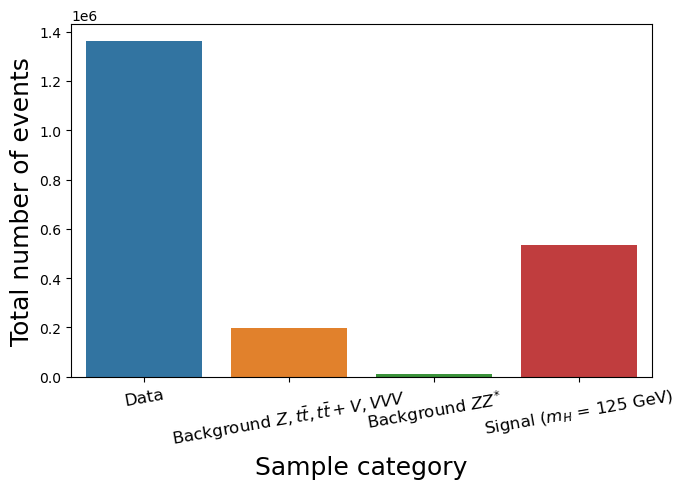

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_totals = pd.DataFrame({
    "Sample": list(event_totals.keys()),
    "TotalEvents": list(event_totals.values())
})

plt.figure(figsize=(6.8, 3.2))

sns.barplot(
    data=df_totals,
    x="Sample",
    y="TotalEvents",
    hue="Sample"
)

plt.ylabel("Total number of events", fontsize = 18)
plt.xlabel("Sample category", fontsize = 18)

plt.xticks(rotation=10, ha="center", fontsize = 12)
#plt.title("Total events processed per dataset category")
#plt.grid(True)
plt.tight_layout()
plt.savefig("total_events_per_category.pdf")
plt.show()

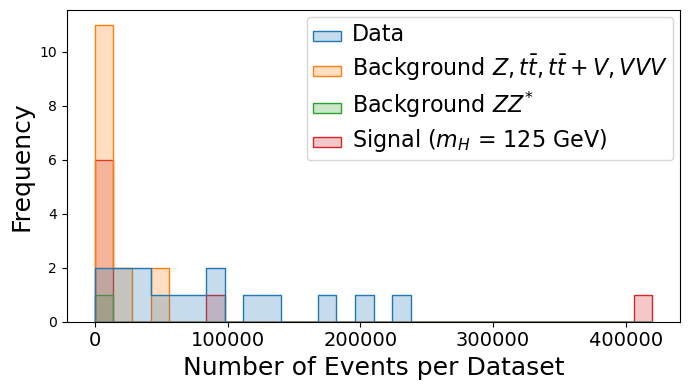

In [38]:
df_events = pd.DataFrame(event_counts)
plt.figure(figsize=(7, 4))

sns.histplot(
    data=df_events,
    x="nIn",
    hue="sample",
    bins=30,
    element="step",
    stat="count",
    common_norm=False
)

plt.xlabel("Number of Events per Dataset", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize = 14)
ax = plt.gca()
legend = ax.get_legend()
legend.set_title(None)
for text in legend.get_texts():
    text.set_fontsize(16)

plt.tight_layout()
plt.savefig("event_count_distribution.pdf")
plt.show()
